In [3]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils import graph_tools, qaoaCUDAQ as q, graph_tools
import networkx as nx
import time

cudaq.set_target("nvidia")

In [4]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import QAOAAnsatz
from qiskit_optimization.translators import to_ising
from qiskit.result import marginal_distribution

In [5]:
def po_normalize(B, P, ret, cov):
    P_b = P / B
    ret_b = ret * P_b
    cov_b = np.diag(P_b) @ cov @ np.diag(P_b)
    
    n_max = np.int32(np.floor(np.log2(B/P))) + 1
    n_qs = np.cumsum(n_max)
    n_qs = np.insert(n_qs, 0, 0)
    n_qubit = n_qs[-1]
    C = np.zeros((len(P), n_qubit))
    for i in range(len(P)):
         for j in range(n_max[i]):
              C[i, n_qs[i] + j] = 2**j

    P_bb = C.T @ P_b
    ret_bb = C.T @ ret_b
    cov_bb = C.T @ cov_b @ C
    return P_bb, ret_bb, cov_bb, int(n_qubit)

def ret_cov_to_QUBO(ret: np.ndarray, cov: np.ndarray, P: np.ndarray, lamb: float, q:float) -> np.ndarray:
    di = np.diag(ret + lamb * (P*P + 2*P))
    mat = 2 * lamb * np.outer(P, P) + q * cov
    return di - mat

def qubo_to_ising(qubo: np.ndarray, lamb: float) -> cudaq.SpinOperator:
    spin_op = lamb
    for i in range(qubo.shape[0]):
        for j in range(qubo.shape[1]):
                if i != j:
                    spin_op += qubo[i, j] * ((spin.i(i) - spin.z(i)) / 2 * (spin.i(j) - spin.z(j)) / 2)
                else:
                    spin_op += qubo[i, j] * (spin.i(i) - spin.z(i)) / 2
    return spin_op

# HAMILTONIAN BY CUDAQ

In [6]:
B = 100
ret = np.array([5, 2, 1])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 1 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)


[[0.80654946 1.06655194 0.80264387]
 [1.06655194 1.30027918 1.61373124]
 [0.80264387 1.61373124 0.12980055]]
n_qubit: 3


In [7]:
a = [True, False, True]
print(sum(a))

b = [[True, False, True], [True, False, False]]
b = sorted(b, key=lambda x: sum(x), reverse=False)
print(b)

2
[[True, False, False], [True, False, True]]


In [8]:
print("Hamiltonian:", H)
HH = H.get_raw_data()
# print(HH[0])
# print(HH[1])


idxs = [[j - len(HH[0][i])//2 for j in range(len(HH[0][i])) if HH[0][i][j]] for i in range(len(HH[0]))]
# print(idxs)

HH = [(idxs[i], HH[1][i], sum(HH[0][i])) for i in range(len(HH[0]))]
HH = sorted(HH, key=lambda x: (x[2], x[0]), reverse=False)

idx_1 = []
coeff_1 = []
idx_2_a, idx_2_b = [], []
coeff_2 = []
for i in range(len(HH)):
    if HH[i][2] == 1:
        idx_1.append(HH[i][0][0])
        coeff_1.append(HH[i][1].real)
    elif HH[i][2] == 2:
        idx_2_a.append(HH[i][0][0])
        idx_2_b.append(HH[i][0][1])
        coeff_2.append(HH[i][1].real)
print(HH)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: [1+0j] IZZ
[1+0j] ZIZ
[1+0j] ZII
[-1+0j] IIZ
[-1.5+0j] III
[1+0j] ZZI
[-0.5+0j] IZI

[([], (-1.5+0j), 0), ([0], (1+0j), 1), ([1], (-0.5+0j), 1), ([2], (-1+0j), 1), ([0, 1], (1+0j), 2), ([0, 2], (1+0j), 2), ([1, 2], (1+0j), 2)]
[0, 1, 2]
[1.0, -0.5, -1.0]

[0, 0, 1]
[1, 2, 2]
[1.0, 1.0, 1.0]


# QISKIT QAOA

In [ ]:
# # cov[0, 2] = cov[2, 0] = 1
# print(cov)
# portfolio_qis = PortfolioOptimization(
#     expected_returns=ret,
#     covariances=cov,
#     risk_factor=0,
#     budget=1,
#     bounds=[(0, 1), (0, 1), (0, 1)]
# )
# qp = portfolio_qis.to_quadratic_program()
# converter = QuadraticProgramToQubo()
# qubo = converter.convert(qp)
# op, offset = to_ising(qubo)

[[0.80654946 1.06655194 0.80264387]
 [1.06655194 1.30027918 1.61373124]
 [0.80264387 1.61373124 0.12980055]]


In [ ]:
# opp = op.to_sparse_list()
# print(opp)
# idx_1_qis = []
# coeff_1_qis = []
# idx_2_a_qis, idx_2_b_qis = [], []
# coeff_2_qis = []

# for i in range(len(opp)):
#     if len(opp[i][1]) == 1:
#         idx_1_qis.append(opp[i][1][0])
#         coeff_1_qis.append(opp[i][2].real)
#     elif len(opp[i][1]) == 2:
#         idx_2_a_qis.append(opp[i][1][0])
#         idx_2_b_qis.append(opp[i][1][1])
#         coeff_2_qis.append(opp[i][2].real)

# print(idx_1_qis)
# print(coeff_1_qis, end="\n\n")
# print(idx_2_a_qis)
# print(idx_2_b_qis)
# print(coeff_2_qis)

[('Z', [0], np.complex128(-2+0j)), ('Z', [1], np.complex128(-3.5+0j)), ('Z', [2], np.complex128(-4+0j)), ('ZZ', [0, 1], np.complex128(4.5+0j)), ('ZZ', [0, 2], np.complex128(4.5+0j)), ('ZZ', [1, 2], np.complex128(4.5+0j))]
[0, 1, 2]
[np.float64(-2.0), np.float64(-3.5), np.float64(-4.0)]

[0, 0, 1]
[1, 2, 2]
[np.float64(4.5), np.float64(4.5), np.float64(4.5)]


In [ ]:
# qaoa_ansatz = QAOAAnsatz(op, reps=2)
# decomposed = qaoa_ansatz.decompose(reps=2)
# decomposed.draw(output='text')

┌─────────┐┌───────────────┐                              ┌──────────────┐»
q_0: ┤ U2(0,π) ├┤ Rz(-4.0*γ[0]) ├─■──────────────■─────────────┤ Rx(2.0*β[0]) ├»
     ├─────────┤├───────────────┤ │ZZ(9.0*γ[0])  │             └──────────────┘»
q_1: ┤ U2(0,π) ├┤ Rz(-7.0*γ[0]) ├─■──────────────┼──────────────■──────────────»
     ├─────────┤├───────────────┤                │ZZ(9.0*γ[0])  │ZZ(9.0*γ[0])  »
q_2: ┤ U2(0,π) ├┤ Rz(-8.0*γ[0]) ├────────────────■──────────────■──────────────»
     └─────────┘└───────────────┘                                              »
«     ┌───────────────┐                                               »
«q_0: ┤ Rz(-4.0*γ[1]) ├──────────────────■──────────────■─────────────»
«     └┬──────────────┤┌───────────────┐ │ZZ(9.0*γ[1])  │             »
«q_1: ─┤ Rx(2.0*β[0]) ├┤ Rz(-7.0*γ[1]) ├─■──────────────┼─────────────»
«      ├──────────────┤├───────────────┤                │ZZ(9.0*γ[1]) »
«q_2: ─┤ Rx(2.0*β[0]) ├┤ Rz(-8.0*γ[1]) ├────────────────■─────────────»
«      └──────────────┘└───────────────┘                              »
«     ┌──────────────┐                
«q_0: ┤ Rx(2.0*β[1]) ├────────────────
«     └──────────────┘┌──────────────┐
«q_1: ─■──────────────┤ Rx(2.0*β[1]) ├
«      │ZZ(9.0*γ[1])  ├──────────────┤
«q_2: ─■──────────────┤ Rx(2.0*β[1]) ├
«                     └──────────────┘

In [ ]:
# qaoa = QAOA(
#     optimizer=COBYLA(maxiter=1000),
#     reps=2,
#     sampler=Sampler()
# )

# meo = MinimumEigenOptimizer(qaoa)

# # result = meo.solve(qubo)

/tmp/ipykernel_4650/1029843751.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler()


In [ ]:
# qaoa_result = qaoa.compute_minimum_eigenvalue(operator=op)
# print("Optimized parameters:", qaoa_result.optimal_point)

Optimized parameters: [ 0.25236706 -0.56562356  4.1614383  -6.34402007]


In [ ]:
# counts = qaoa_result.eigenstate
# counts = np.array(list(counts.values()))

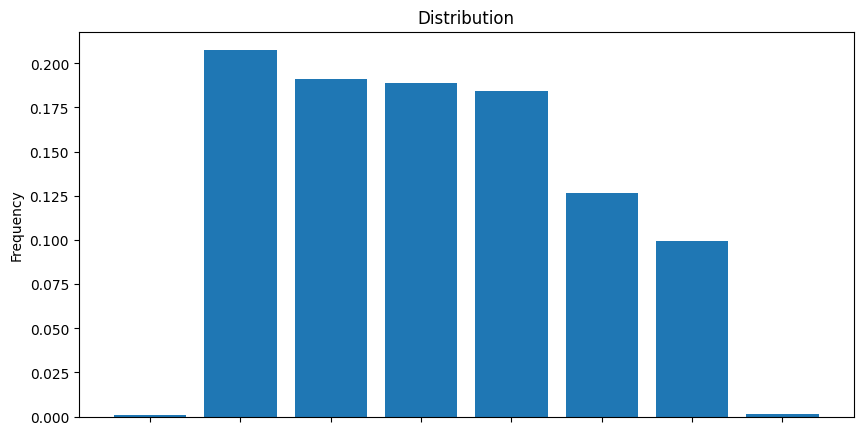

In [ ]:
# plt.figure(figsize=(10, 5))
# # plt.bar(range(2**qubit_count), list(result.values()))
# plt.bar(range(2**op.num_qubits), counts)
# # plt.xlabel('Cut')
# plt.ylabel('Frequency')
# plt.title('Distribution')
# # plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.show()

# CUDA QAOA

In [16]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [17]:
# print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

In [18]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float]):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)

    for i in range(layer_count):
        # for idxs, coeff, l in sorted_raw_ham:
        #     if l == 1:
        #         rz(2 * coeff * thetas[i], qreg[idxs[0]])
        #     elif l == 2:
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        #         rz(2 * coeff * thetas[i], qreg[idxs[1]])
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        # for i in range(qubit_count):
        #     rx(2.0 * thetas[layer_count + i], qreg[i])

        for j in range(len(idx_1)):
            rz(2 * coeff_1[j] * thetas[i], qreg[idx_1[j]])
        
        for j in range(len(idx_2_a)):
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])
            rz(2 * coeff_2[j] * thetas[i], qreg[idx_2_b[j]])
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])

        for j in range(qubit_count):
            rx(2.0 * thetas[layer_count + i], qreg[j])

In [19]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [20]:
print(cudaq.draw(kernel_qaoa_ham, 3, 2, [0.1]*4, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use))

     ╭───╮╭─────────╮                                           ╭─────────╮»
q0 : ┤ h ├┤ rz(0.2) ├───●───────────────●────●───────────────●──┤ rx(0.2) ├»
     ├───┤├─────────┴╮╭─┴─╮╭─────────╮╭─┴─╮  │               │  ╰─────────╯»
q1 : ┤ h ├┤ rz(-0.1) ├┤ x ├┤ rz(0.2) ├┤ x ├──┼───────────────┼───────●─────»
     ├───┤├──────────┤╰───╯╰─────────╯╰───╯╭─┴─╮╭─────────╮╭─┴─╮   ╭─┴─╮   »
q2 : ┤ h ├┤ rz(-0.2) ├─────────────────────┤ x ├┤ rz(0.2) ├┤ x ├───┤ x ├───»
     ╰───╯╰──────────╯                     ╰───╯╰─────────╯╰───╯   ╰───╯   »

################################################################################

╭─────────╮                                                                 »
┤ rz(0.2) ├──────────────────────────────●───────────────●────●─────────────»
╰─────────╯     ╭─────────╮╭──────────╮╭─┴─╮╭─────────╮╭─┴─╮  │             »
─────────────●──┤ rx(0.2) ├┤ rz(-0.1) ├┤ x ├┤ rz(0.2) ├┤ x ├──┼─────────────»
╭─────────╮╭─┴─╮├─────────┤├──────────┤╰───╯╰─────────╯╰───╯╭─┴─╮╭

In [21]:
idx = 4
layer_count = 2

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.max_iterations = 1000

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [-0.15729142489334527, 0.09930030590735955, 0.040519756389447326, 0.33753155902322074]


In [22]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_ham, H, n_qubit, layer_count, parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [23]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -4.689730951387901
optimal_parameters = [-0.3577301688162047, -0.43793720743737535, 0.6229836938517548, 0.5914838856255232]
Time taken =  1.0420424938201904


In [28]:
shots_count = int(1e7)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 10000000 times...
Finding the best solution...
100 7555861 0.7555861
|q0>|q1>|q2>...


In [25]:
assert False

AssertionError: 

In [26]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

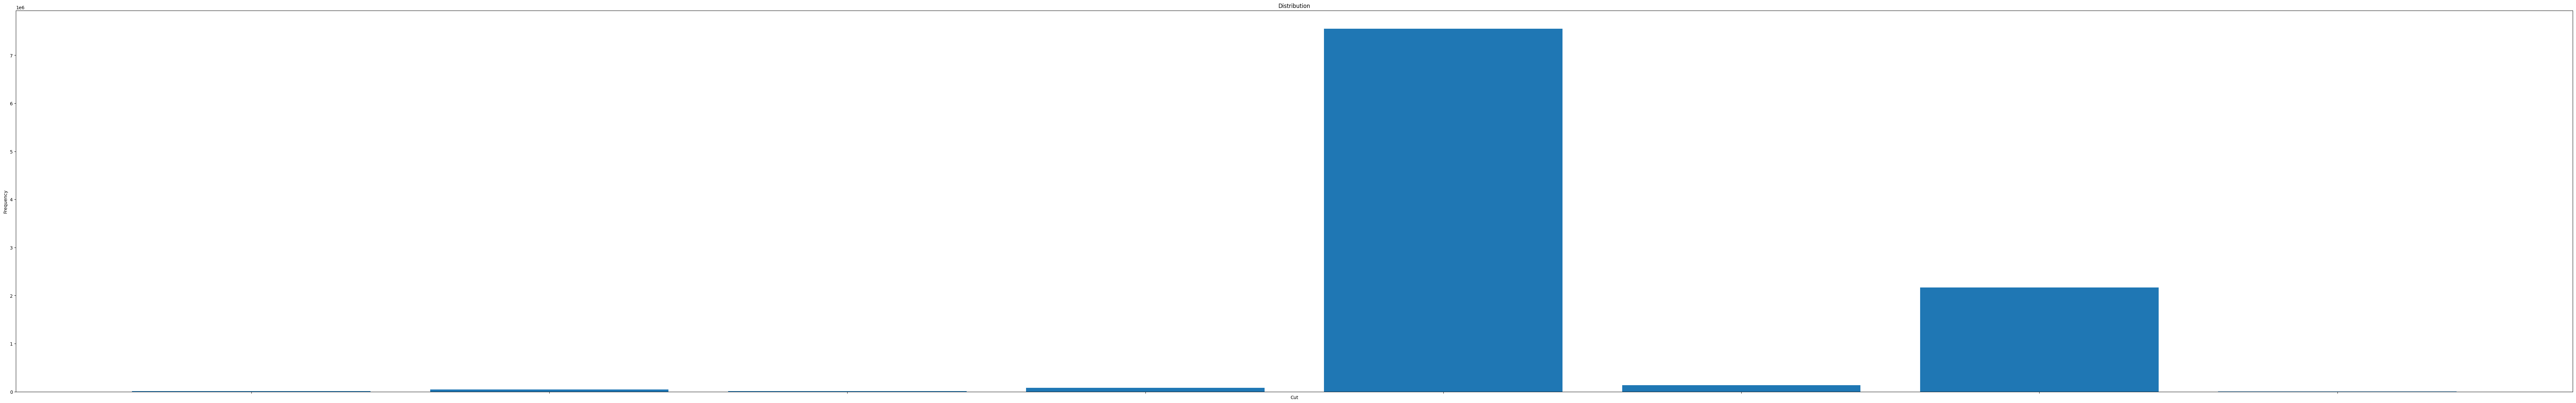

In [27]:
plt.figure(figsize=(100, 15))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Distribution')
plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Loading expectations from COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Loading expectations from GradientDescent


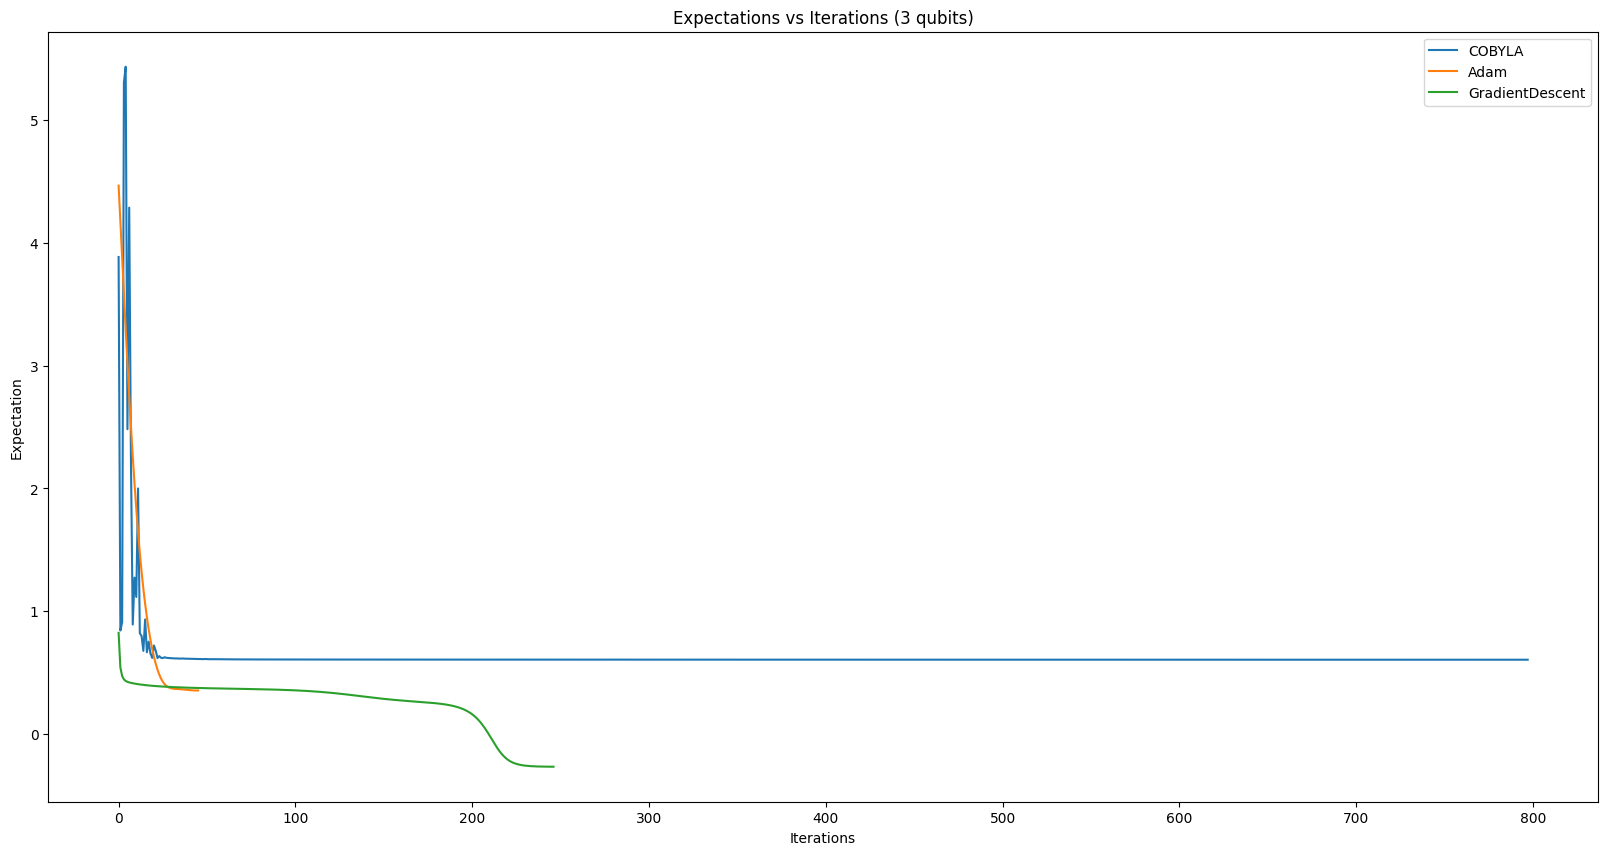

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()